In [1]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns
import spacy
import transformers
import torch

from datasets import Dataset
from hdbscan import HDBSCAN
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering
)
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM
)
from umap import UMAP
from wordcloud import WordCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Read data

In [2]:
data_dir = "../data"
train_data_path = os.path.join(data_dir, 'train_data_llava.json')
test_data_path = os.path.join(data_dir, 'test_data_llava.json')
models_dir = "../models"

def generate_df_from_json(json_path):
  with open(json_path) as f:
    data: dict = json.load(f)
    data_formated= {'caption': [], 'label': []}
    for value in data.values():
      data_formated['caption'].append(value['caption'])
      data_formated['label'].append(value['label'])
  
  df = pd.DataFrame.from_dict(data_formated)
  return df

id2label = {
  0: 'Cultural_Religious',
  1: 'Fauna_Flora',
  2: 'Gastronomy',
  3: 'Nature',
  4: 'Sports',
  5: 'Urban_Rural'
}

label2id = {
  'Cultural_Religious': 0,
  'Fauna_Flora': 1,
  'Gastronomy': 2,
  'Nature': 3,
  'Sports': 4,
  'Urban_Rural': 5
}

train_df = generate_df_from_json(train_data_path)
train_df['Label'] = train_df['label'].replace(id2label)
test_df = generate_df_from_json(test_data_path)
test_df['Label'] = test_df['label'].replace(id2label)

#train_data = Dataset.from_pandas(train_df).train_test_split(test_size=0.15, seed=4999)
#test_data = Dataset.from_pandas(train_df)
#print(train_data)

## Generate embeddings

In [3]:
embedding_model = SentenceTransformer("all-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("paraphrase-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to('cuda')

def generate_embeddings(df: pd.DataFrame, text_col: str):
    sentences = df[text_col].tolist()
    embeddings = embedding_model.encode(sentences)

    return embeddings
    
train_embeddings = generate_embeddings(train_df, 'caption')
test_embeddings = generate_embeddings(test_df, 'caption')

/home/nacho/Proyects/image-topic-clustering/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Dimensionality reduction (UMAP)

We are going to reduce dimensonality:
1. For documents visualization, with 2 dimensions
2. For documents clustering, with more dimensions

### For documents visualization

In [4]:
viz_reducer = UMAP(n_neighbors=15, n_components=2, metric='cosine')
viz_train_reduced = viz_reducer.fit_transform(train_embeddings)

<Axes: xlabel='x', ylabel='y'>

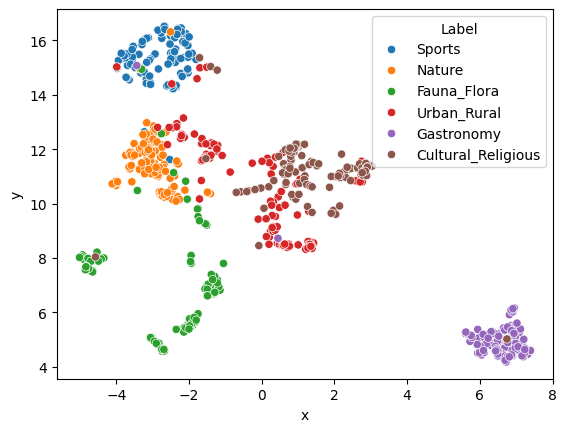

In [5]:
train_df['x'] = viz_train_reduced[:, 0]
train_df['y'] = viz_train_reduced[:, 1]
sns.scatterplot(
    train_df, x='x', y='y', 
    hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)

### For clustering

In [6]:
reducer = UMAP(n_neighbors=15, n_components=20, metric='cosine')
train_reduced = reducer.fit_transform(train_embeddings)

## Clustering

### HDBSCAN

In [7]:
clusterer = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
clusterer.fit(train_reduced)

HDBSCAN(min_cluster_size=20, prediction_data=True)

/tmp/ipykernel_3886/1165245163.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.scatterplot(


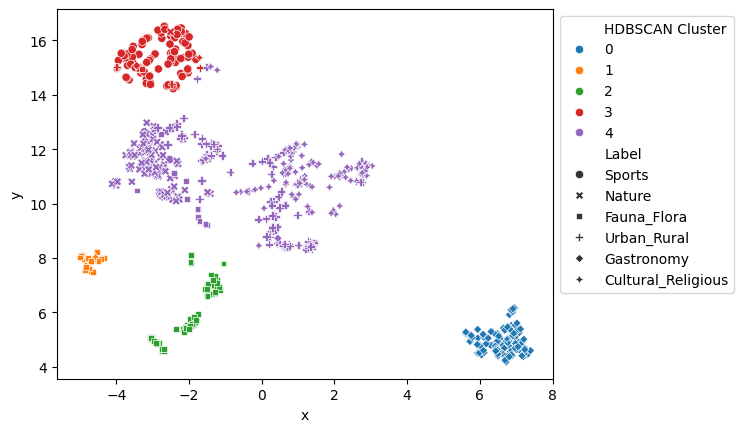

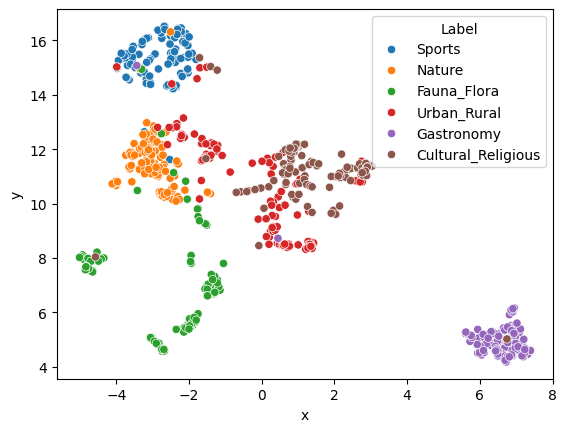

In [8]:
train_df['HDBSCAN Cluster'] = clusterer.labels_
ax = sns.scatterplot(
    train_df, x='x', y='y', hue='HDBSCAN Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=10)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

<Axes: ylabel='$\\lambda$ value'>

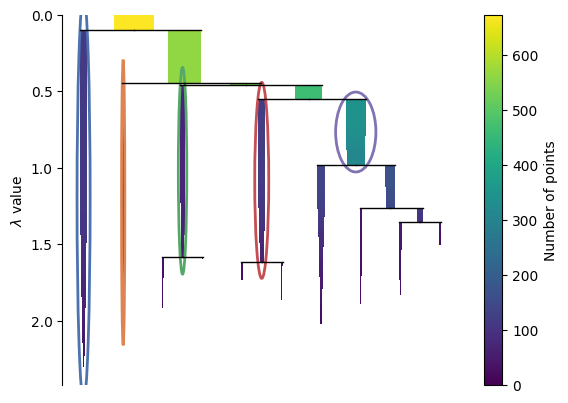

In [9]:
clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 8)
)

### KMeans

In [10]:
kmeans_clusterer = AgglomerativeClustering(n_clusters=6)#, n_init=20, max_iter=10000)
kmeans_clusterer.fit(train_reduced)

AgglomerativeClustering(n_clusters=6)

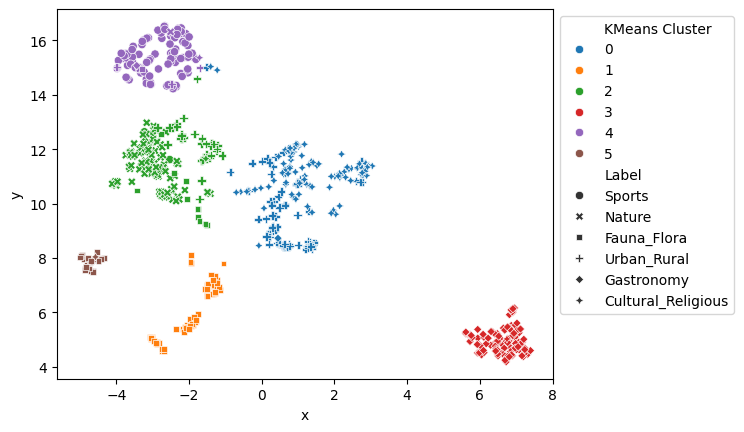

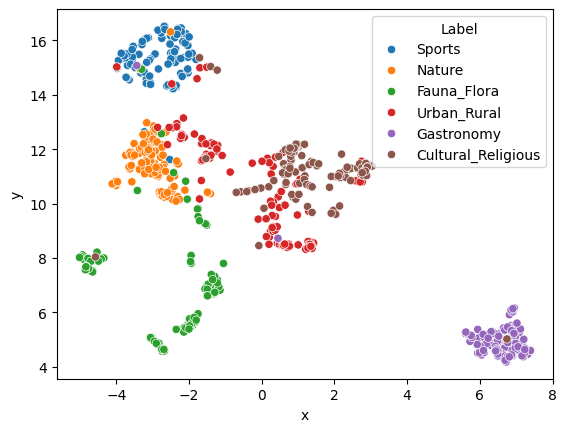

In [11]:
train_df['KMeans Cluster'] = kmeans_clusterer.labels_
ax=sns.scatterplot(
    train_df, x='x', y='y', hue='KMeans Cluster', style='Label',
    palette=sns.color_palette("tab10", n_colors=6)
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position outside the plot
plt.show()

sns.scatterplot(
    train_df, x='x', y='y', hue='Label', 
    palette=sns.color_palette("tab10", n_colors=6)
)
plt.show()

## Clusters BoW

Cluster 0


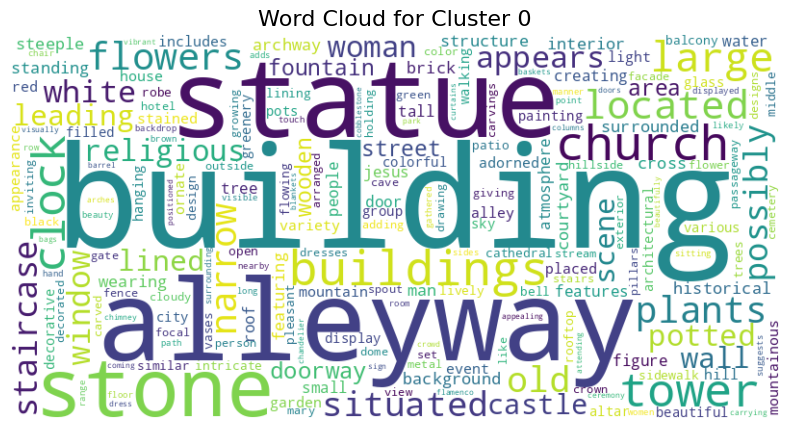

building: 0.4865
alleyway: 0.2867
statue: 0.2699
stone: 0.2301
buildings: 0.2259
church: 0.2259
tower: 0.2136
clock: 0.2024
large: 0.1597
located: 0.1440


Cluster 1


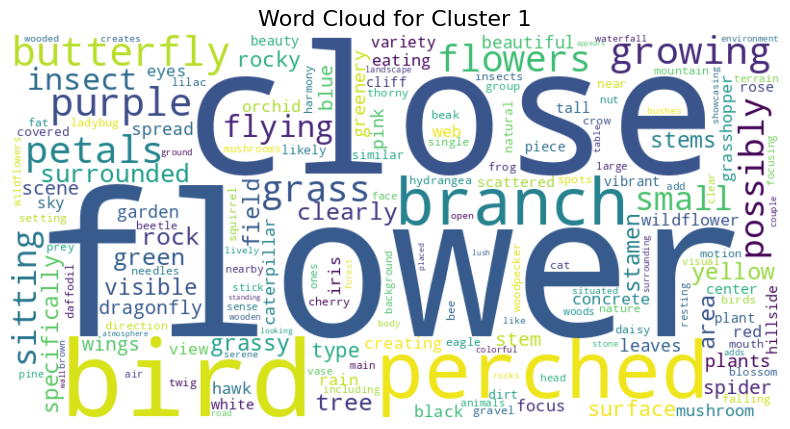

flower: 0.4588
close: 0.3621
bird: 0.3560
perched: 0.3221
branch: 0.2374
butterfly: 0.1695
purple: 0.1643
growing: 0.1526
petals: 0.1526
flowers: 0.1409


Cluster 2


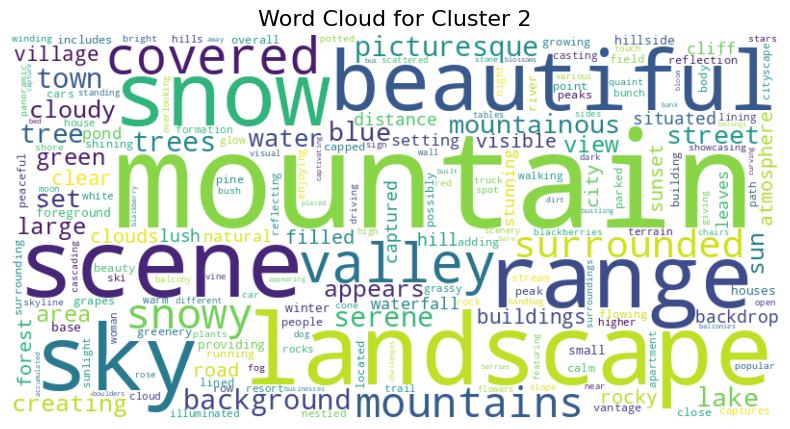

mountain: 0.5356
landscape: 0.2481
scene: 0.2320
sky: 0.2153
snow: 0.2129
range: 0.2044
beautiful: 0.2016
valley: 0.1513
covered: 0.1459
mountains: 0.1362


Cluster 3


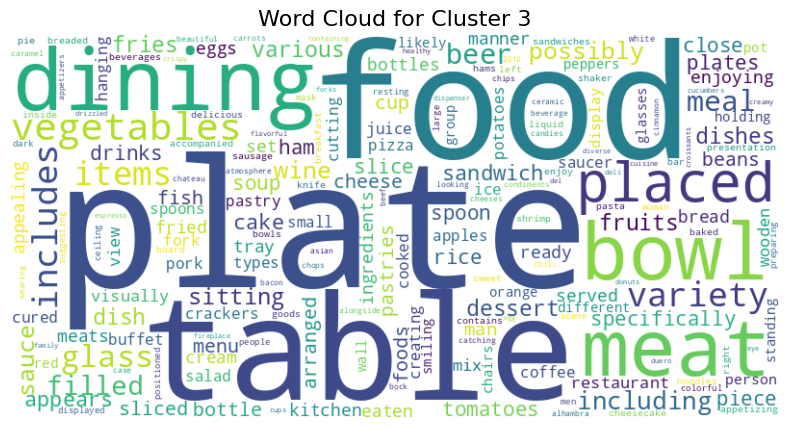

plate: 0.5810
food: 0.4547
table: 0.3760
dining: 0.2021
meat: 0.1768
bowl: 0.1705
placed: 0.1456
vegetables: 0.1453
includes: 0.1161
variety: 0.1124


Cluster 4


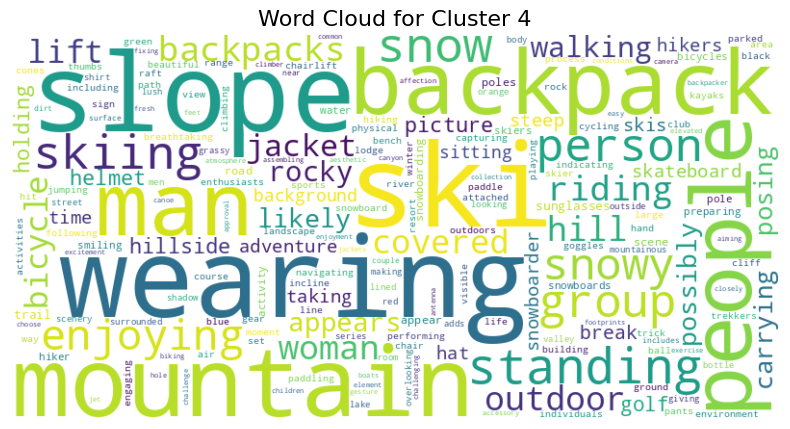

ski: 0.2982
wearing: 0.2795
slope: 0.2668
mountain: 0.2648
backpack: 0.2393
man: 0.2354
people: 0.2157
standing: 0.1827
snow: 0.1789
skiing: 0.1727


Cluster 5


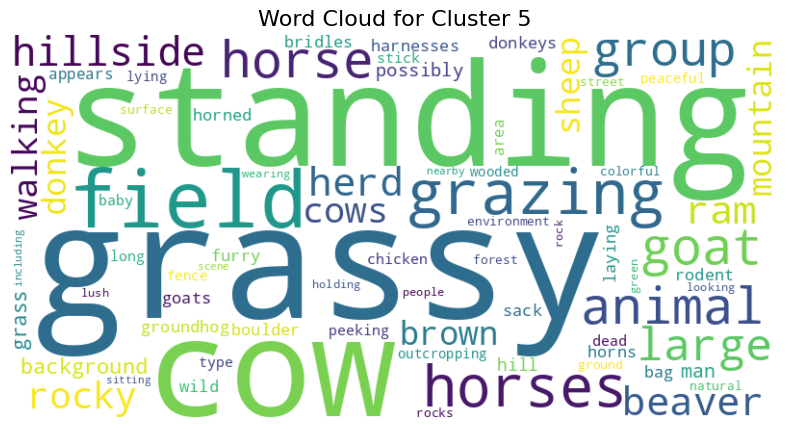

grassy: 0.4321
standing: 0.3435
cow: 0.3186
field: 0.3032
grazing: 0.2731
horses: 0.2276
animal: 0.1821
goat: 0.1821
horse: 0.1821
group: 0.1632




In [12]:
# Step 1: Combine all documents in the same cluster into a single document
clustered_docs = train_df.groupby('KMeans Cluster')['caption'].apply(' '.join).reset_index()
clustered_docs['caption'] = clustered_docs['caption'].str.replace('image', '')
clustered_docs['caption'] = clustered_docs['caption'].str.replace('shows', '')

# Step 2: Calculate the TF-IDF for the combined documents
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(clustered_docs['caption'])

# Step 3: Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Step 4: Extract the top 10 words with the highest TF-IDF score for each cluster
top_n = 10
clusters_words = {}
for idx, row in enumerate(tfidf_matrix):
    representative_words = []
    cluster = clustered_docs['KMeans Cluster'][idx]
    print(f"Cluster {cluster}")
    # Get the TF-IDF scores for the row and corresponding feature names
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    # Convert to dictionary (word: tf-idf score)
    tfidf_dict = {word: score for word, score in tfidf_scores}
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}', fontsize=16)
    plt.show()
    # Sort by TF-IDF score in descending order and get the top N words
    tfidf_scores = zip(feature_names, row.toarray().flatten())
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:top_n]
    for word, score in sorted_scores:
        representative_words.append(word)
        print(f"{word}: {score:.4f}")
    print("\n")
    clusters_words[cluster] = representative_words
    

## Zero-shot cluster classification

In [27]:
llama_model_id = 'google/flan-t5-large'
labels = ['Sports', 'Nature', 'Urban and rural', 'Flora and fauna', 'Gastronomy', 'Cultural and religious']

def generate_zero_shot_classification_prompt(words, labels):
    prompt = f"""Giveng the following keywords from a cluster, classify the cluster into one category.

Keywords: {', '.join(words)}

Categories: {', '.join(labels)}
"""
    return prompt

def generate_label_generator_prompt(words):
    prompt = f"""Generate a short label (max. 3 words) that represents the cluster described by the keywords below. The label should represent the visitor who took the photo.

Keywords: {', '.join(words)}"""
    return prompt

def classify_text(model, tokenizer, words, labels, max_length=150):
    prompt = generate_zero_shot_classification_prompt(words, labels)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=max_length)

    # Decode the generated text
    category = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract the category from the generated text
    return category

def generate_label(model, tokenizer, words, max_length=3):
    prompt = generate_label_generator_prompt(words)
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(inputs["input_ids"], max_length=max_length)

    # Decode the generated text
    label = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return label


In [14]:

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(llama_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(
    llama_model_id,
    load_in_4bit=True,
    device_map="auto",  # This automatically places the model on the available GPUs
    torch_dtype=torch.float16,  # You can use bfloat16 or float16 for better memory usage
)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/home/nacho/Proyects/image-topic-clustering/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [28]:

for cluster, words in clusters_words.items():
    category = classify_text(model, tokenizer, words, labels)
    label = generate_label(model, tokenizer, words)
    print(f"Words: {', '.join(words)}")
    print(f"Category: {category}")
    print(f"Label: {label}")
    print("----------------------------")

    

Words: building, alleyway, statue, stone, buildings, church, tower, clock, large, located
Category: Urban and rural
Label: large stone
----------------------------
Words: flower, close, bird, perched, branch, butterfly, purple, growing, petals, flowers
Category: Flora and fauna
Label: close up
----------------------------
Words: mountain, landscape, scene, sky, snow, range, beautiful, valley, covered, mountains
Category: Nature
Label: beautiful scene
----------------------------
Words: plate, food, table, dining, meat, bowl, placed, vegetables, includes, variety
Category: Gastronomy
Label: A plate
----------------------------
Words: ski, wearing, slope, mountain, backpack, man, people, standing, snow, skiing
Category: Sports
Label: people standing
----------------------------
Words: grassy, standing, cow, field, grazing, horses, animal, goat, horse, group
Category: Nature
Label: group of
----------------------------
